In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
heart = pd.read_csv('heart.csv')

In [2]:
heart.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [3]:
from pycaret.classification import *
#intialize the setup
exp_clf = setup(heart, target = 'HeartDisease')

In [4]:
from pycaret.datasets import get_data
dataset = get_data('heart', profile=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
### Cholesterol with many Zeros that doesn't make sense, remove x > 400

dataset[dataset['Cholesterol'] == 0] = dataset['Cholesterol'].median()
dataset['Cholesterol'] = dataset[dataset['Cholesterol'] < 400]

### RestingBP bad distribution

dataset['RestingBP'] = dataset[dataset['RestingBP'] > 80]

In [6]:
data = dataset.sample(frac=0.8, random_state=42).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

In [7]:
compare_models(sort='Recall')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7559, verbose=0,
                       warm_start=False)

In [8]:
model = create_model('catboost', random_state=2202)

In [9]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [11]:
tuned_model = tune_model(model, optimize='Recall')

In [12]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [13]:
tuned_model_recall = tune_model(model, optimize = 'Recall')

In [14]:
unseen_predictions = predict_model(model, data=data_unseen)
unseen_predictions

Age Sex ChestPainType RestingBP Cholesterol  FastingBS RestingECG  MaxHR  \
0     56   M           ASY        56        56.0          1        LVH    103   
1     49   M           NAP        49        49.0          0     Normal    139   
2     54   M           ASY        54        54.0          0        LVH    116   
3     57   M           ASY        57        57.0          0     Normal     88   
4     65   F           NAP        65        65.0          0        LVH    151   
..   ...  ..           ...       ...         ...        ...        ...    ...   
179   45   M            TA        45        45.0          0     Normal    132   
180   68   M           ASY        68        68.0          1     Normal    141   
181   57   M           ASY        57        57.0          0     Normal    115   
182   57   F           ATA        57        57.0          0        LVH    174   
183   38   M           NAP        38        38.0          0     Normal    173   

    ExerciseAngina  Oldpeak ST_Slope  HeartDisease  Label   Score  
0                Y      1.6     Down             1      1  0.9878  
1                N      2.0     Flat             1      1  0.8710  
2                Y      3.2     Flat             1      1  0.9697  
3                Y      1.2     Flat             1      1  0.9727  
4                N      0.8       Up             0      0  0.7647  
..             ...      ...      ...           ...    ...     ...  
179              N      1.2     Flat             1      1  0.8408  
180              N      3.4     Flat             1      1  0.9741  
181              Y      1.2     Flat             1      1  0.9573  
182              N      0.0     Flat             1      0  0.5665  
183              N      0.0       Up             0      0  0.9294  

[184 rows x 14 columns]

<AxesSubplot:>

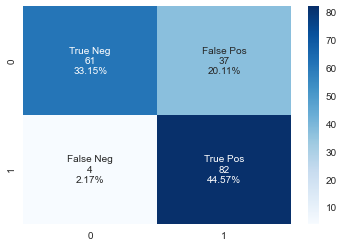

In [15]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
y_true = unseen_predictions['HeartDisease']
y_pred = unseen_predictions['Label']
cf_matrix = confusion_matrix(y_true, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


In [16]:
recall = cf_matrix[1][1] / (cf_matrix[1][1]+cf_matrix[1][0])

In [17]:
recall

0.9534883720930233

In [27]:
# save a model
from datetime import datetime

now = datetime.now().strftime("%d/%m/%Y %H:%M:%S").replace('/','-').replace(':','-')

save_model(model, 'hdp_model_' + str(now))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='HeartDisease',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='HeartDisease')),
                 ('fix_perfect', Remove_100(target='HeartDisease')),
                 ('clean_names', Clean_Colum_Names()),
  